In [1727]:
import random
import torch
import numpy as np
import fastbook
# from fastai.vision.all import Image
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch import tensor
from torch.utils.data import DataLoader
fastbook.setup_book()     


def one_hot(digit):
    return tensor([float(i == digit) for i in range(10)]).unsqueeze(1)


pic_to_matrix = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
matrix_to_column = transforms.Compose([
    transforms.Lambda(torch.flatten),
    transforms.Lambda(lambda x: x.unsqueeze(1)),
])
pic_to_column = transforms.Compose([
    pic_to_matrix,
    matrix_to_column,
])


def to_pic(pixels):
    digit = pixels.numpy().reshape(28,28)
    digit = digit.astype(np.uint8)
    return Image.fromarray(digit).resize((100, 100))


path = fastbook.untar_data(fastbook.URLs.MNIST)


def pic_loader(pic_transform, label_transform=None):
    def loader(path):
        return torchvision.datasets.ImageFolder(
            path.as_posix(),
            transform=pic_transform,
            target_transform=label_transform, 
        )
    return loader


def load_mnist(loader, train_proportion=0.8):
    full_dataset = loader(path / "training")
    
    
    train_size = int(train_proportion * len(full_dataset))
    valid_size = len(full_dataset) - train_size
    training_set, validation_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

    # Dataset using the "testing" folder
    testing_set = loader(path / "testing")
    
    return training_set, testing_set, validation_set


loader = pic_loader(pic_transform=pic_to_column, label_transform=one_hot)
training_set, testing_set, validation_set = load_mnist(loader, train_proportion=0.8)
print(len(training_set), len(testing_set), len(validation_set))

training_set = DataLoader(training_set, batch_size=30, shuffle=True)
testing_set = DataLoader(testing_set, batch_size=30, shuffle=True)
validation_set = DataLoader(validation_set, batch_size=30, shuffle=True)

48000 10000 12000


In [1713]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def graph_updater():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 

    def add_datapoint(y):
        xs, ys = [], []
        if ax.lines:
            xs = ax.lines[0].get_xdata()
            ys = ax.lines[0].get_ydata()

        prev_x = xs[-1] if len(xs) > 0 else 0        

        ax.cla()
        ax.plot(np.append(xs, prev_x + 1), np.append(ys, y))
        
        #ax.set_xlim(0, prev_x + 1)
        ax.set_ylim(0, 1)
        
        display(fig)

        clear_output(wait = True)
    
    return add_datapoint

In [1707]:
def is_correct(expected, output):
    return int(torch.argmax(expected) == torch.argmax(output))
       

def cost(expected, output):
    return torch.sum((expected - output)**2) / 2

In [1708]:
def merge_layer_grads(grads):
    return [torch.stack(i).mean(0) for i in zip(*grads)]
    

def merge_grads(grads):
    return [merge_layer_grads(l) for l in zip(*grads)]

In [1705]:
def l2(a, b):
    return torch.sum((a - b)**2) / 2

class Network:
    def __init__(self, layers, lr=0.001, nonlinearity=torch.nn.Sigmoid(), deriv=lambda x: x * (1 - x), cost_func=l2):
        self.activation = nonlinearity
        self.deriv = deriv
        self.cost_func = cost_func
        self.lr = lr
        self.w = [torch.rand(n_out, n_in) / torch.sqrt(tensor(n_in)) for n_in, n_out in zip(layers, layers[1:])]
        self.b = [torch.rand(n_out, 1) for n_out in layers[1:]]
        
    def forward(self, inputs):
        a = inputs
        activations = [a]
        for w, b in zip(self.w, self.b):
            a = self.activation(w @ a + b)
            activations.append(a)
        return activations
         
    def step(self, inputs):
        return self.forward(inputs)[-1]
    
    def gradient(self, activations, expected):
        layer_gradients = []
       
        in_ = activations[-2]
        out = activations[-1]

        nabla_C = out - expected
        sigma_L = self.deriv(out)
        delta_L = nabla_C * self.deriv(out)

        prev_delta = delta_L
        
        dw = prev_delta @ torch.transpose(in_, 0, 1) 
        db = prev_delta 
        layer_gradients.append([dw, db])
        
        for l in range(len(self.w) - 2, -1, -1):
            in_ = activations[l]
            out = activations[l+1]
            
            delta_l = (torch.transpose(self.w[l+1], 0, 1) @ prev_delta) * self.deriv(out)
            prev_delta = delta_l
            
            dw = delta_l @ torch.transpose(in_, 0, 1)
            db = delta_l
            
            layer_gradients.append([dw, db])
        
        return list(reversed(layer_gradients))
    
    def update(self, gradient, lr):
        for i, (w, b) in enumerate(gradient):
            self.w[i] -= lr * w
            self.b[i] -= lr * b
        

In [1737]:
def run_epoch(network, dataset, lr):
    accuracy = []
    costs = []
    
    for batch in iter(dataset):
        grads = []
        for xs, expected in zip(*batch):
            activations = network.forward(xs)
            output = activations[-1]
            grad = network.gradient(activations, expected)
            grads.append(grad)
            accuracy.append(is_correct(expected, output))
            costs.append(cost(expected, output))
         
        grad = merge_grads(grads)
        network.update(grad, lr)

    return tensor(accuracy).float().mean(), torch.stack(costs).mean()


def train(network, dataset, epochs, lr, show_progress=True):
    if show_progress:
        add_datapoint = graph_updater()
    
    for epoch in range(epochs):
        start = datetime.now()
        
        avg_accuracy, avg_cost = run_epoch(network, dataset, lr)
        
        if show_progress and (not epoch % 1):
            print(f'epoch {epoch}: accuracy={round(avg_accuracy.item(), 3)}, cost={round(avg_cost.item(), 3)}, time: {datetime.now() - start}')
            add_datapoint(avg_accuracy)
    
    return avg_accuracy, avg_cost

In [1738]:
n = Network((28*28, 50, 10))

(tensor(0.8986), tensor(0.0799))

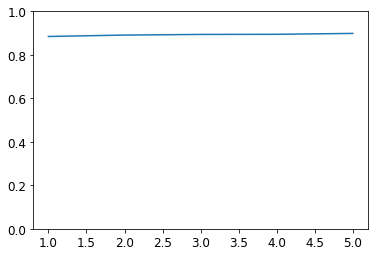

In [1740]:
train(n, training_set, 5, lr=3)